In [1]:
import collections
import functools
import itertools
import re
import string
import timeit

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import sklearn

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

from utils import *
from topic_utils import *

In [2]:
# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

In [ ]:
nltk.download('popular')

# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. We can perform our analysis on
- individual tweets
- all tweets for a grouping of the dataframe (e.g. group by userid)
- all tweets in the corpus

In addition,
- hashtags and urls are already in a separate column, as a list of strings.

In general, we want to convert tweet text into tokens for analysis. We will make utility functions which anticipate tokenizing for these levels of analysis.

1. Individual tweets are strings; groups of tweets are lists of strings
1. Preprocessing:
    1. Remove uninformative symbols
    1. Remove 'RT'
    1. Replace urls, hashtags, and @-mentions with generic tokens
    1. Remove stopwords
    1. Lemmatize
1. Apply preprocessing to column of strings OR column of lists of strings
    - Treat column of strings as a single list of strings

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [4]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [5]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

### Pipeline usage

We can test our pipeline for tokenizing the datasets by aggregating all tweets for each user, allowing us to characterize users by the overall contents of their activity.

Aggregation for tweet text can be defined as joining tweet strings into a list of strings:

In [6]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head()

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


In [7]:
def make_tokens(list_of_strings,
                stop_words=[*stopwords.words(),
                          '<-url->', '<-@->', '<-#->', 
                          '...','`',',','-',"'"]):
    """Apply preprocessing and tokenization to a list of strings.
    Usage: 
            output = make_tokens(series_of_strings)

            output = df.apply(make_tokens)
            
    Return:
        A list of lists of tokens for each string.
    """    
    
    t1 = default_timer()

    processed_strings = [preprocess_string(string)
                         for string in list_of_strings]

    tokenized_strings = [tokenize_string(string,
                                         stop_words)
                          for string in processed_strings]
                         
    t2 = default_timer()
    print('elapsed', t2 - t1)
    
    return tokenized_strings

In [8]:
(user_tweets['tweet_text'].head(1)
               .map(make_tokens))

elapsed 0.029287318990100175


userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=    [[america, way, government, treats, people, mu...
Name: tweet_text, dtype: object

In [9]:
user_tokens = (user_tweets['tweet_text']
               .map(make_tokens)
               .map(long_list))

elapsed 0.025712668022606522
elapsed 0.033167951041832566
elapsed 0.14309555100044236
elapsed 0.5286280030268244
elapsed 4.702450935030356
elapsed 3.8234830379951745
elapsed 2.1290851950179785
elapsed 0.8479519280372187
elapsed 3.851617256994359
elapsed 0.38574229000369087
elapsed 0.1014398870174773
elapsed 91.87737430201378
elapsed 0.14271314797224477
elapsed 0.20357779099140316
elapsed 0.09369270200841129
elapsed 0.08402454201132059
elapsed 0.03382945997873321
elapsed 0.013939798052888364
elapsed 0.0018976560095325112
elapsed 0.213567121012602
elapsed 0.5419435650110245
elapsed 0.206079815980047
elapsed 0.4980372120044194
elapsed 0.0017318690079264343
elapsed 2.1410079990164377
elapsed 0.020545179955661297
elapsed 0.9685539290076122
elapsed 2.186094863980543
elapsed 0.03169457596959546
elapsed 0.0010209539905190468
elapsed 0.03128478501457721
elapsed 0.0856301580206491
elapsed 0.0743045499548316
elapsed 0.49127593298908323
elapsed 0.12579319899668917
elapsed 0.012149126967415214
elap

In [10]:
user_tokens

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treats, people, mus...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, مقاومت, کمک, نکنه, خاک, تو, ...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [women, prefer, vote, rapest, pedophile, reall...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     [good, look, tweet, agree, like, severe, hatre...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     [hapus, zionisme, hapus, penjajahan, israel, l...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      [karl, marx, leader, nothing, dems, asking, cr...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     [sick, tired, lied, amazing, go, vote, better,...
zk4khaX7A3XhX

### Count word frequencies

In [11]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'} sorted by frequency (high to low)
    """
    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [12]:
corpus_freq_dict = word_frequency(long_list(user_tokens))
corpus_freq_dict

{'via': 40982,
 'completa': 25234,
 'trump': 22581,
 'irán': 18853,
 'eeuu': 18729,
 'yang': 18361,
 'از': 15240,
 'video': 14313,
 'که': 13992,
 'در': 13853,
 'historia': 13126,
 'israel': 12269,
 'nota': 11551,
 'presidente': 11395,
 'people': 11139,
 'palestina': 9959,
 'gobierno': 9752,
 'silver': 9506,
 'biden': 9431,
 'را': 8700,
 'us': 8408,
 'siria': 8101,
 'این': 8013,
 'با': 7939,
 'iraní': 7619,
 'país': 7290,
 'uploaded': 6882,
 'ejército': 6880,
 'mueos': 6699,
 'است': 6216,
 'nuevo': 6134,
 'fuerzas': 5987,
 'added': 5639,
 'ataque': 5634,
 'terroristas': 5628,
 'militar': 5510,
 'playlist': 5423,
 'president': 5318,
 'crisis': 5273,
 'orang': 5230,
 'رو': 5173,
 'amp': 5099,
 'pide': 5067,
 'vote': 5056,
 'xttxkplli': 5019,
 'china': 4985,
 'tras': 4951,
 'acuerdo': 4943,
 'price': 4930,
 'guerra': 4882,
 'mundo': 4760,
 'rusia': 4734,
 'régimen': 4643,
 'vía': 4613,
 'تو': 4606,
 'like': 4541,
 'allah': 4496,
 'nuclear': 4495,
 'venezuela': 4415,
 'world': 4406,
 'líder

In [13]:
top_user = (campaign
           .groupby('userid')
           .size()
           .idxmax())
user_tweets.loc[top_user]

tweet_text    [¡Quedan 3 episodios para el final!\nSerie "El...
Name: 213589457, dtype: object

In [14]:
top_user_tokens = user_tokens.loc[top_user]
top_user_tokens[:20]

['quedan',
 'episodios',
 'final',
 'serie',
 'profeta',
 'josé',
 'días',
 'gmt',
 'repite',
 'nicaragua',
 'país',
 'seguro',
 'centroamérica',
 'competencia',
 'militares',
 'israelíes',
 'matar',
 'palestinos',
 'construcción',
 'empresa']

In [15]:
document_freq_dict = word_frequency(top_user_tokens)

## Word cloud

In [16]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

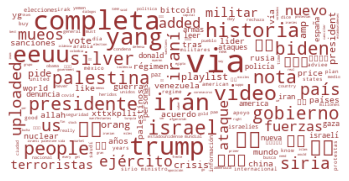

In [17]:
# TODO: render Arabic
fig = visualize(corpus_freq_dict)

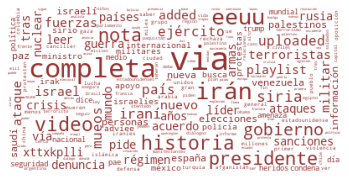

In [18]:
fig = visualize(document_freq_dict)

### Hashtag frequency + word cloud

In [19]:
hashtags = (campaign
               .loc[:]['hashtags']
               .fillna('')
               )
hashtag_list = [el.strip() for el in long_list(hashtags)
               if el != '']

In [20]:
hashtag_freq = word_frequency(hashtag_list)

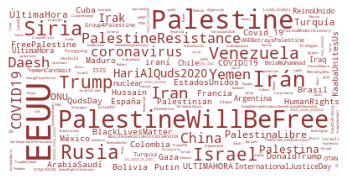

In [21]:
fig = visualize(hashtag_freq)

In [22]:
print('unique hashtags: {}'.format(len(hashtag_freq)))

unique hashtags: 37964


## Vectorizing

Using sklearn's Vectorizers to turn the corpus into a text-term matrix allows us to easily count tokens, and count n-grams as well as single-word tokens.

In [23]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
stop_words = [*stopwords.words(),
              '<-url->', '<-@->', '<-#->', 
              '...','`',',','-',"'",'"']
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, placeholders=True)

In [26]:
vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

documents_list = (user_tweets['tweet_text']
                    .map(long_string)
                   )

In [27]:
documents_list[:5]

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    @VoteMarsha Why Women Prefer to Vote for an ra...
Name: tweet_text, dtype: object

In [28]:
# tokenize + construct the frequency matrix from tokens
matrix = vectorizer.fit_transform(documents_list)

In [29]:
# get token names + frequencies
ngrams = vectorizer.get_feature_names()
ngram_frequencies = matrix.sum(axis=0).tolist()[0]
freq_dict = dict(zip(ngrams, ngram_frequencies))

In [30]:
matrix

<209x2596879 sparse matrix of type '<class 'numpy.int64'>'
	with 3461500 stored elements in Compressed Sparse Row format>

In [31]:
sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:20]

[('via', 40982),
 ('completa', 25234),
 ('trump', 22581),
 ('irán', 18854),
 ('eeuu', 18730),
 ('yang', 18361),
 ('از', 15240),
 ('video', 14313),
 ('که', 13992),
 ('در', 13853),
 ('historia', 13126),
 ('israel', 12269),
 ('historia completa', 12192),
 ('nota', 11551),
 ('nota completa', 11445),
 ('presidente', 11395),
 ('people', 11139),
 ('palestina', 9959),
 ('gobierno', 9752),
 ('silver', 9506)]

# Topic extraction

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [32]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model which models a corpus as a random mixture of topics and uses the observed words to fit latent variables describing the mixture of topics and the distribution of words in the documents of the corpus.

A corpus consists of $D$ documents ($\sim$vector samples) of $N$ words ($\sim$entry samples) described by $K$ topics ($\sim$classes).

1. For each topic $k \in K$, draw $\beta_{k} \sim \text{Dirichlet}(\eta)$. This represents the probability of a word appearing in topic $k$.


1. For each document $d \in D$: draw the topic proportions $\theta_{d} \sim \text{Dirichlet}(\alpha).$

1. For each word $i$ in document $D$:
    1. Draw the topic assignment $z_{di} \sim \text{Multinomial}(\theta_{d})$
    2. Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$
p(z,\theta,\beta\mid w,\alpha,\eta) = \frac{p(z,\theta,\beta\mid\alpha,\eta)}{p(w\mid\alpha,\eta)}
$$

Variational Bayesian method uses a simpler distribution to approximate the posterior distribution and optimizes parameters in an expectation-minimization procedure. Variational parameters are optimized to maximize the Evidence Lower Bound (ELBO) - maximizing ELBO is equivalent to minimizing the Kullback-Leibler (KL) divergence between the estimate $q$ and the true posterior $p$.

In [33]:
vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             # TODO: preprocessing strings - remove characters??
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

In [34]:
t1 = default_timer()

tf = vectorizer.fit_transform(documents_list)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

elapsed: 46.111810987989884


In [35]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 32.480404258007184


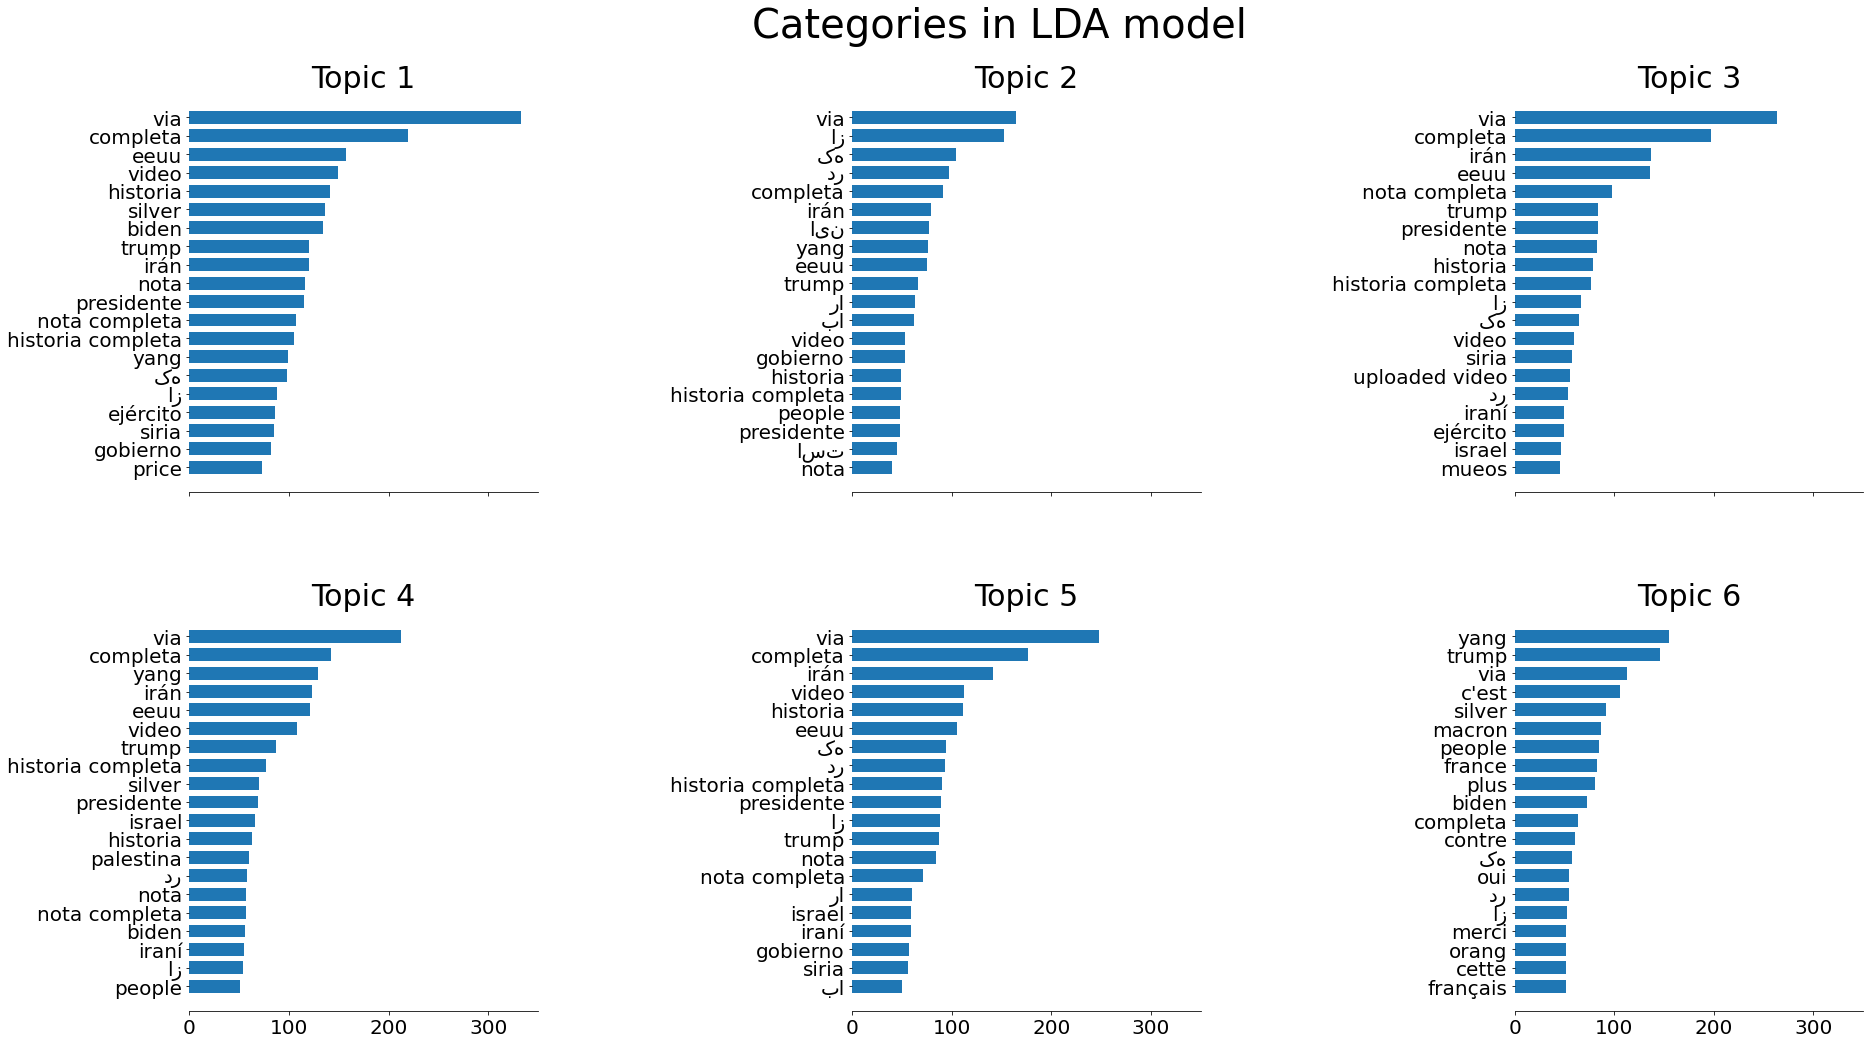

<Figure size 432x288 with 0 Axes>

In [36]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               6,
               'Categories in LDA model')
plt.tight_layout()

Because the "document" level used in this case was per-user tweet token aggregates, we can perhaps consider these topics to be analogous to categories of users, based on their overall tweet set. Considering this campaign was so long, it is likely that the specific topics of tweets changed over time, so in further analysis, we might perform more filtering of the tweets in advance of clustering, for instance isolating tweets from a certain period of time.

In [37]:
"""Variational parameters for topic word distribution. 

Since the complete conditional for topic word distribution is a 
Dirichlet, components_[i, j] can be viewed as pseudocount that 
represents the number of times word j was assigned to topic i. 
It can also be viewed as distribution over the words for each 
topic after normalization: 
model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
"""
lda.components_

array([[0.70523367, 0.61167079, 0.70114386, ..., 0.54474208, 0.68649847,
        0.56168346],
       [0.62499518, 0.58830823, 0.55635474, ..., 0.5550857 , 0.59958432,
        0.58618837],
       [0.54018946, 0.59233694, 0.56529386, ..., 0.67365202, 0.62076869,
        0.57734074],
       ...,
       [0.58935379, 0.5255051 , 0.56968122, ..., 0.62304453, 0.66897676,
        0.50470249],
       [0.56450129, 0.7189578 , 0.58975388, ..., 0.54692289, 0.6292271 ,
        0.51859631],
       [1.45255876, 0.91909653, 1.16722166, ..., 0.89321132, 0.52756219,
        0.60172081]])

### Utility function

N.B. this applies the custom string preprocessing and then also sklearn's preprocessing

In [38]:
def extract_topics(documents,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=[*stopwords.words(),
                                  '<-url->', '<-@->', '<-#->', 
                                  '...','`',',','-',"'",
                                  '.','^',],
                   ):
    
    vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=stop_words,
                                 ngram_range=(1,2),
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )
    if apply_preprocessing:
        documents_list = (documents
                            .map(long_string)
                            .map(preprocess_string)
                         )
    else: documents_list = documents

    print('vectorizing...')
    t1 = default_timer()
    tf = vectorizer.fit_transform(documents_list)
    
    print('elapsed: {}'.format(default_timer() - t1))
    
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

In [39]:
stop_words = [*stopwords.words(),
              '<-url->', '<-@->', '<-#->', 
              '...','`',',','-',"'",'"']
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, placeholders=True)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

In [ ]:
extract_topics(user_tweets['tweet_text'],
               n_components=6)

vectorizing...
elapsed: 31.479625379957724
LDA:
n_samples: 2000
n_features: 1000
n_components: 6


### To do:
- mixtures of languages in topics? apply analysis to tweets separated by language? translate things?
- removing single characters re: arabic and emojis?